In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    I believe I could have just used torch.nn.MultiheadAttention but their documentation
    is all but absent and code ugly so I don't trust it, rolling my own here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, -1e10) # todo: just use float('-inf') instead?
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

In [ ]:
import math
import logging

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        if self.config.ckpt_path is not None:
            ckpt_model = self.model.module if hasattr(self.model, "module") else self.model
            logger.info("saving %s", self.config.ckpt_path)
            torch.save(ckpt_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config

        # create the optimizer
        no_decay = ["bias", "LayerNorm.weight"]
        params_decay = [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)]
        params_nodecay = [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)]
        optim_groups = [
            {"params": params_decay, "weight_decay": config.weight_decay},
            {"params": params_nodecay, "weight_decay": 0.0},
        ]
        optimizer = optim.AdamW(optim_groups, lr=config.learning_rate, betas=config.betas)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, batch_size=config.batch_size, num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

            if not is_train:
                logger.info("test loss: %f", np.mean(losses))

        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                run_epoch('test')

            self.save_checkpoint()

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [ ]:
# set up logging
import logging
import pandas as pd
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [ ]:
# make deterministic
#from mingpt.utils import set_seed
set_seed(42)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, content):
        chars = sorted(list(set(content)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d smiles, %d unique characters.' % (data_size, vocab_size))
    
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return math.ceil(len(self.data) / (self.block_size + 1))

    def __getitem__(self, idx):
        smiles = self.data[idx]
        len_smiles = len(smiles)
        dix =  [self.stoi[s] for s in smiles]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        
        return x, y

In [ ]:
# you can download this moses file here https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv
f = open('/content/moses.txt')
smiles = f.read().splitlines()
#smiles =# pd.read_csv('/content/dataset_v1.csv')['SMILES']

In [ ]:
# some preprocessin, adding "<" to make every smile of max length (for us '<' is an end token)
lens = [len(i) for i in smiles]
max_len = max(lens)
smiles = [ i + str('<')*(max_len - len(i)) for i in smiles]

In [ ]:
content = ' '.join(smiles)

In [ ]:
block_size = max_len

In [ ]:
train_dataset = CharDataset(smiles, content, )

data has 1584783 smiles, 35 unique characters.


In [ ]:
#from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=256)
model = GPT(mconf)

In [ ]:
#from mingpt.trainer import Trainer, TrainerConfig
import math
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=30, batch_size=128, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=32*20, final_tokens=200*len(train_dataset)*block_size,
                      num_workers=10)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch 1 iter 50: train loss 0.28502. lr 5.999633e-04: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s]
epoch 2 iter 50: train loss 0.23235. lr 5.998532e-04: 100%|██████████| 51/51 [00:33<00:00,  1.51it/s]
epoch 3 iter 50: train loss 0.20597. lr 5.996698e-04: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]
epoch 4 iter 50: train loss 0.18653. lr 5.994130e-04: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]
epoch 5 iter 50: train loss 0.17477. lr 5.990830e-04: 100%|██████████| 51/51 [00:34<00:00,  1.47it/s]
epoch 6 iter 5

In [ ]:
#torch.save(model.state_dict(), '/content/gpt_model_state')


In [ ]:
# alright, let's sample some molecules and draw them using rdkit

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
#from mingpt.utils import sample
import seaborn as sns

In [ ]:
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [ ]:
import tqdm as tqdm

In [ ]:
molecules = []
gen_smiles = []
context = "C"
for i in tqdm.tqdm(range(500)):
    x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=0.7, sample=True, top_k=5)[0]
    completion = ''.join([train_dataset.itos[int(i)] for i in y])
    completion = completion.replace('<', '')
    mol = Chem.MolFromSmiles(completion)
    if mol:
        molecules.append(mol)
        gen_smiles.append(completion)

NameError: ignored

In [ ]:
gen_smiles

['COc1cc(C(=O)Nc2ccccc2)cc(OC)c1OC',
 'Cc1ccc(C(=O)Nc2ccccc2Cl)cc1',
 'COc1ccc(C(=O)Nc2ccc(OC)c(C)c2)cc1',
 'CCOc1ccc(OC)c(NC(=O)CSc2nnc3ccccc3n2)c1',
 'CCOC(=O)c1ccc(NC(=O)c2ccc(C)o2)cc1',
 'Cc1sc2ncnc(NC(=O)c3ccccc3)c2c1C',
 'COc1ccc(-c2nc(C)c(C)c(C(=O)Nc3ccccc3)c2)cc1',
 'COC(=O)c1cccc(NC(=O)COc2ccc(C)c(C)c2)c1',
 'CC(=O)Nc1ccc(-c2ccc3c(c2)OCO3)cc1',
 'Cc1ccc(-c2nnc(C(=O)Nc3ncncc3N)cc2)cc1',
 'COc1cc2nc(SCC(=O)Nc3ccccc3)c(=O)c2cc1',
 'Cc1ccc(C(=O)N2CCN(c3ccccc3)CC2)cc1',
 'COc1ccc(S(=O)(=O)Nc2ccccc2C)cc1',
 'COc1ccc(NC(=O)c2ccc3c(c2)OCO3)cc1',
 'COc1ccc(-n2nnnc2-c2ccccc2C(C)(C)C)cc1',
 'Cc1ccc(S(=O)(=O)Nc2ccccc2C(F)(F)F)cc1',
 'COc1ccc(NC(=O)c2cccc(Cl)c2)cc1',
 'COc1ccc(C(=O)Nc2ccc(F)cc2)cc1OC',
 'Cc1cccc(C(=O)Nc2ccc(C(F)(F)F)cc2)c1',
 'COc1cccc(OC)c1C(=O)Nc1ccc(C)cc1',
 'CCOC(=O)Nc1cccc(NC(=O)c2cccs2)c1',
 'COc1nc2c(cc1S(=O)(=O)c1ccccc1)CC2',
 'Cc1nnc(NC(=O)CSc2ncnc3ccccc3n2C)s1',
 'COc1cccc(C(=O)Nc2ccc(OC)cn2)c1',
 'COC(=O)c1ccccc1NC(=O)c1ccccc1',
 'COc1ccc(CNS(=O)(=O)c2ccccc2)cc1

In [ ]:
"Valid molecules % = {}".format(len(molecules))

'Valid molecules % = 319'

In [ ]:
mol_dict = []
for i in molecules:
    mol_dict.append({'molecule' : i, 'qed': qed(i), 'smiles': Chem.MolToSmiles(i)})

In [ ]:
results = pd.DataFrame(mol_dict)

,molecule,qed,smiles
0,,0.878882,COC(=O)c1cccc(NC(=O)c2ccc(C)c(C)c2)c1
1,,0.881082,COC(=O)c1sc(NS(=O)(=O)c2ccccc2)cc1C
2,,0.707781,Cc1onc(-c2ccccc2)c1OCc1ccccc1
3,,0.678701,COC(=O)c1nc(N)cc(C(=O)c2cccs2)c1C#N
4,,0.783312,Cc1ccc(OCC(=O)Nc2ccc3ccccc3c2)cc1
5,,0.941276,CN(C)S(=O)(=O)c1cccc(NC(=O)c2ccccc2)c1
6,,0.807600,Cc1ccc(-n2nc(C(N)=O)c(-c3csc(C)c3)n2)cc1
7,,0.878873,COc1ccc(C2Cc3ccccc3NC(=O)N2)cc1
8,,0.876200,COc1cc(S(=O)(=O)Nc2ccc(C)c(C)c2)cc(OC)c1O
9,,0.864057,CCOC(=O)N1CCN(c2cccc(OC)c2)c2ccccc21

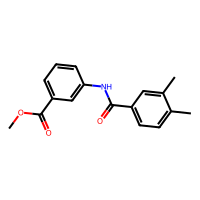
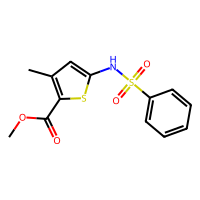
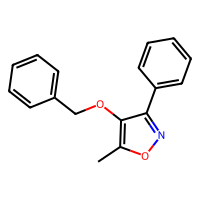
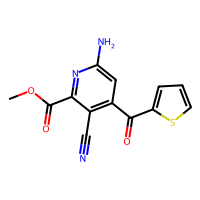
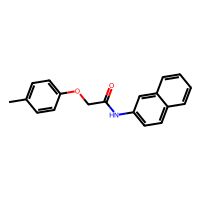
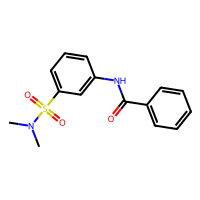
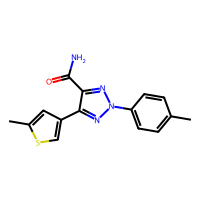
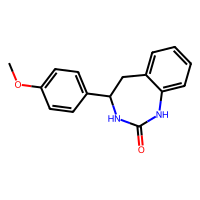
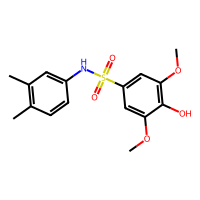
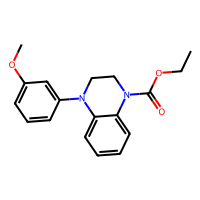
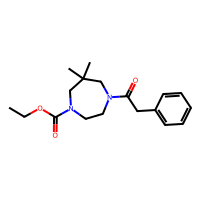
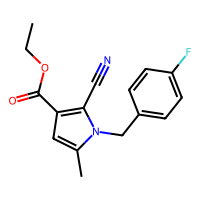
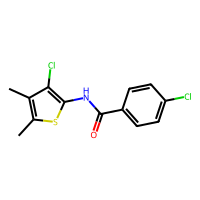
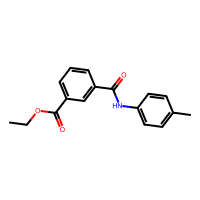
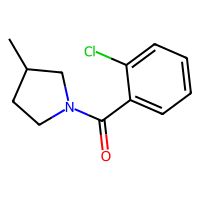
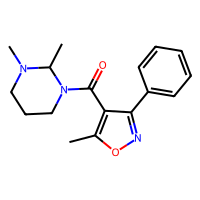
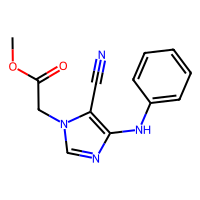
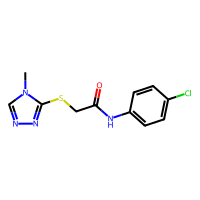
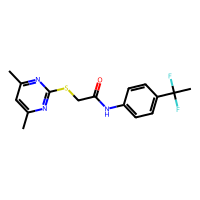
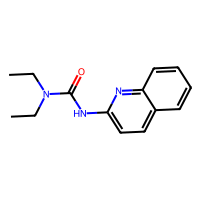
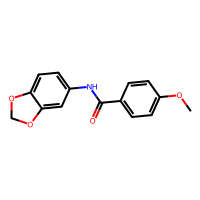
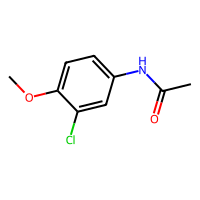
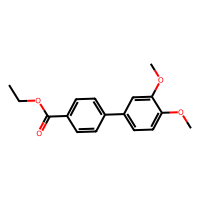
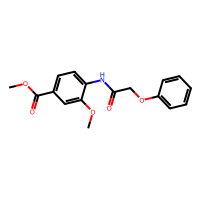
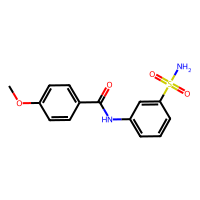
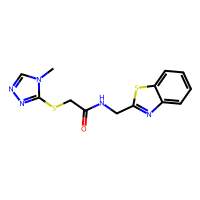
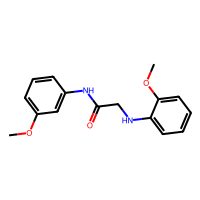
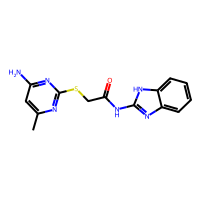
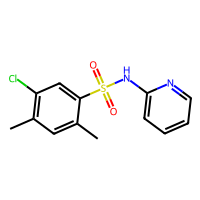
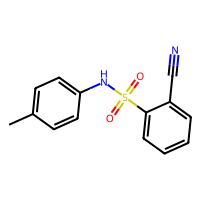
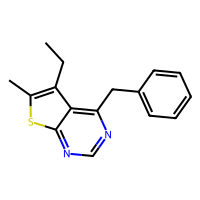
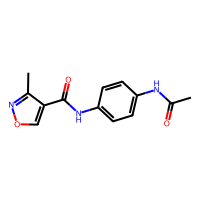
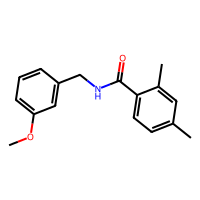
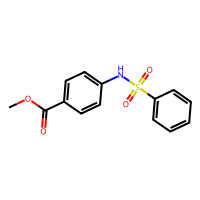
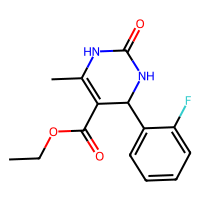
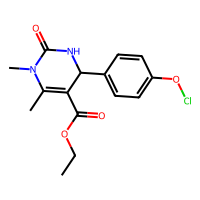
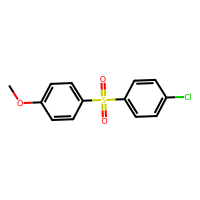
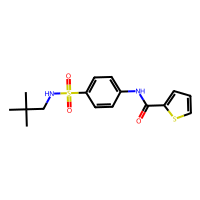
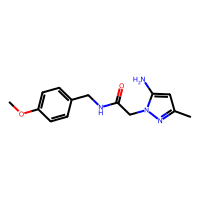
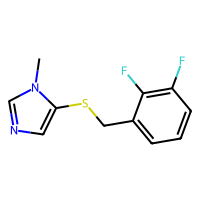
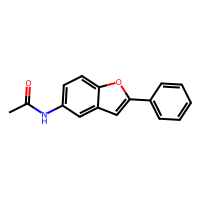
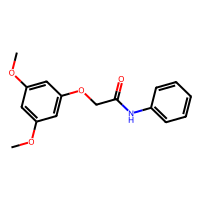
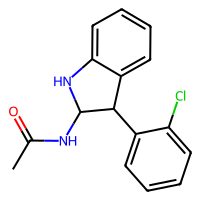
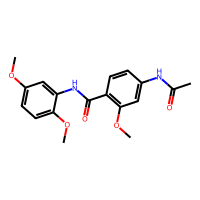
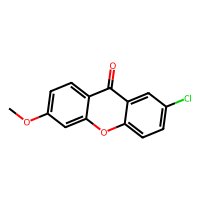
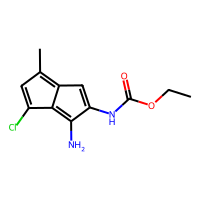
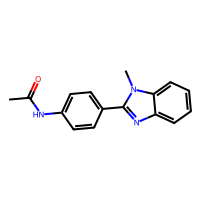
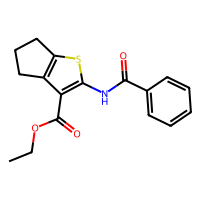
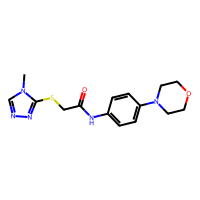
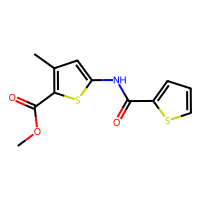
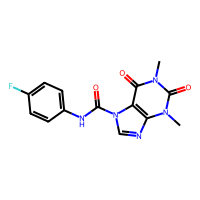
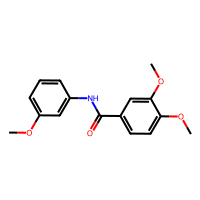
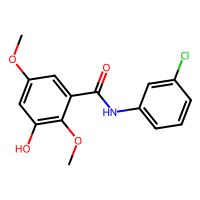
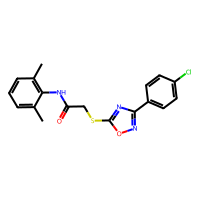
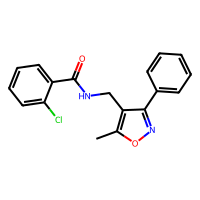
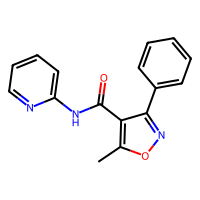
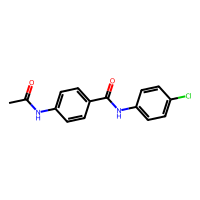

In [ ]:
results

Text(0.5, 1.0, 'QED plot')

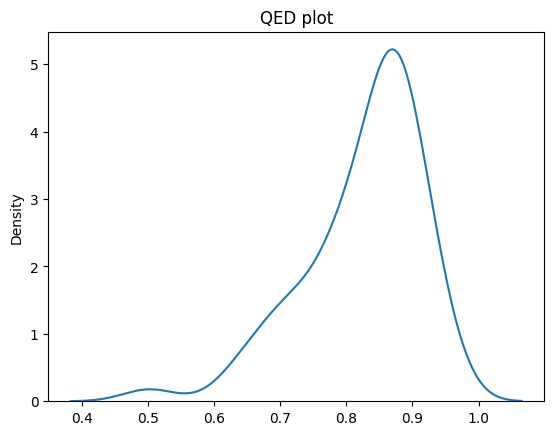

In [ ]:
import matplotlib.pyplot as plt
sns.kdeplot(results['qed'].values)
plt.title('QED plot')

,molecule,qed,smiles
0,,0.677112,CCOC(=O)c1cnn(-c2nc(C)nc3sc(CC)c(C)c23)c1C
1,,0.728099,CCc1cccc(CC(=O)Cn2cnc3ccccc3c2=O)c1
2,,0.783137,CC(C)(C)NC(=O)Nc1ccc(C(=O)NC(C)(C)C)cc1
3,,0.895424,CC(=O)Nc1ccc(NC(=O)Cc2ccccc2)cc1
4,,0.742755,Cn1c(=O)c2c(ncn2CC(=O)Nc2ccc(F)cc2)n(C)c1=O
5,,0.806002,CCOC(=O)c1c[nH]c2ccc(OC)cc12
6,,0.745607,CC(=O)c1ccc(NC(=O)c2cccc(-n3cnnn3)c2)cc1
7,,0.727011,Cc1ccccc1NC(=O)CSc1nnc(-c2ccco2)o1
8,,0.689722,COc1ccc(NC(=O)Cn2nnc(-c3ccccc3N)n2)cc1
9,,0.622855,CN(C)C(=O)CSc1nc2ccccc2c(=O)n1C

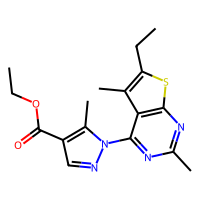
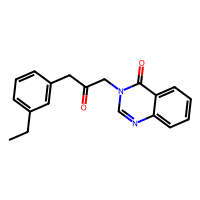
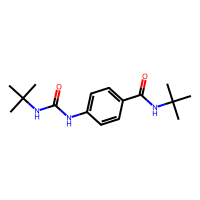
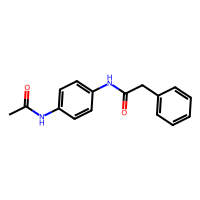
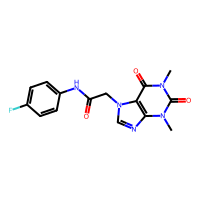
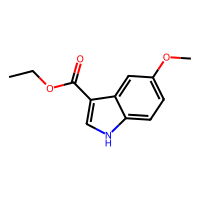
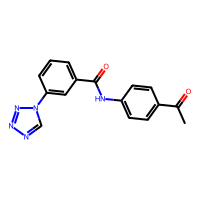
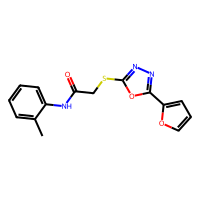
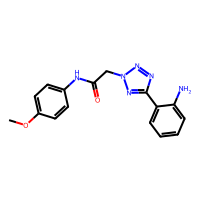
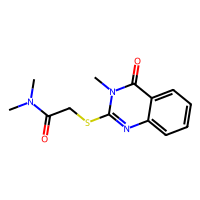
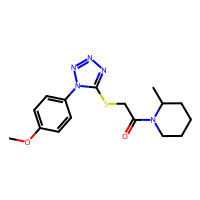
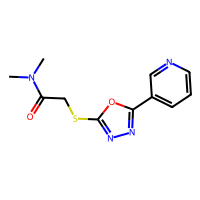
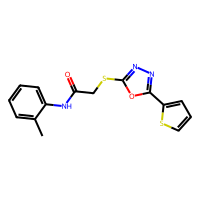
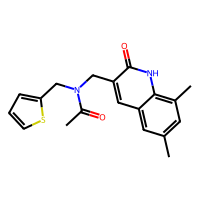
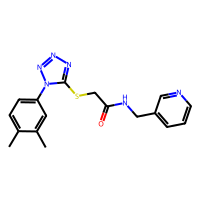
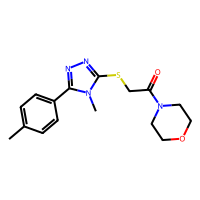
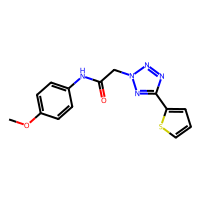
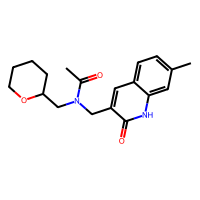
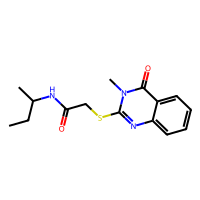
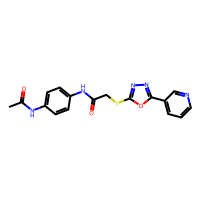
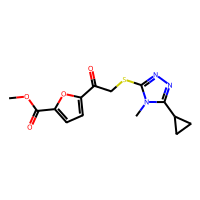
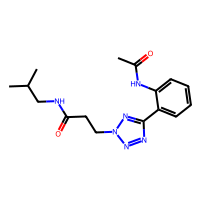
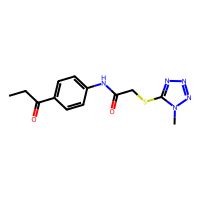
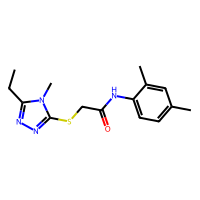
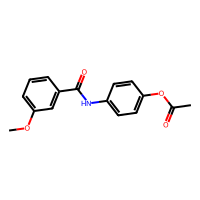
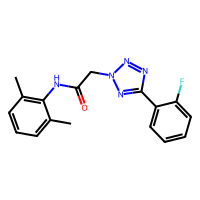
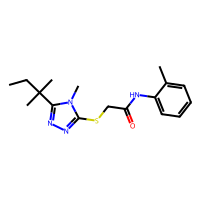
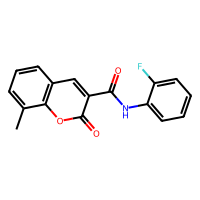
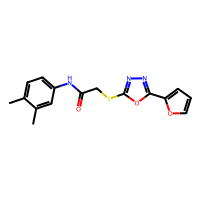
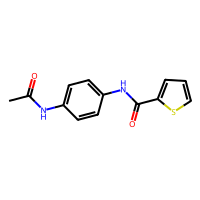
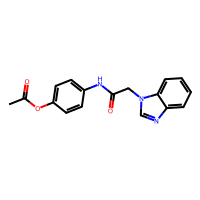
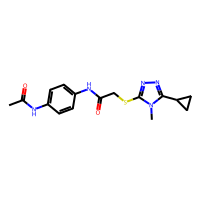
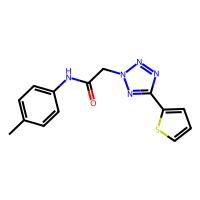
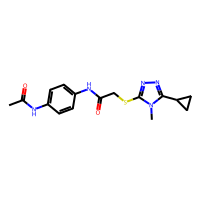
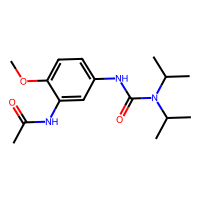
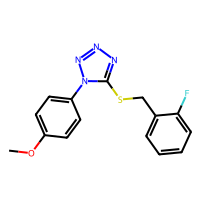
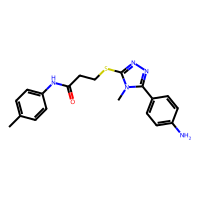
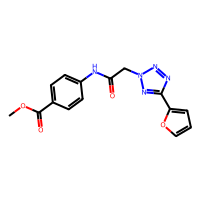
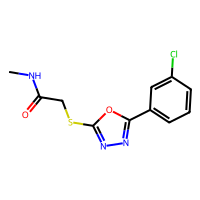
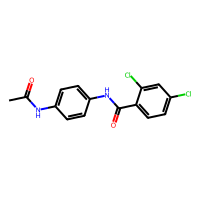
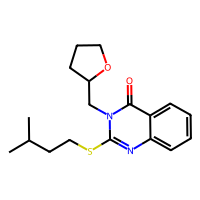
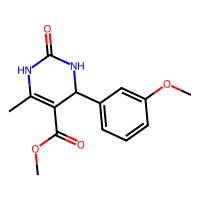
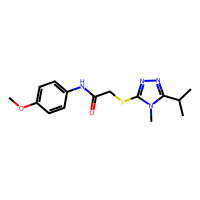
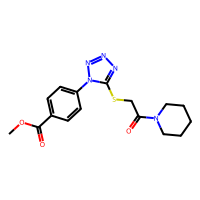
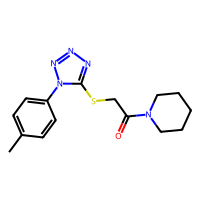
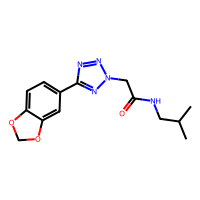
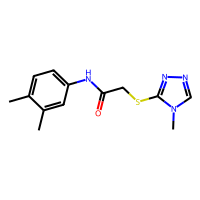
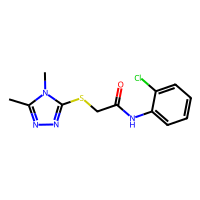
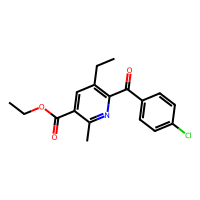
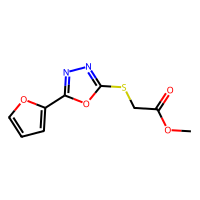
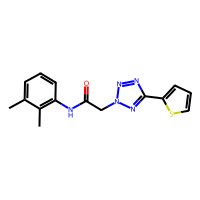
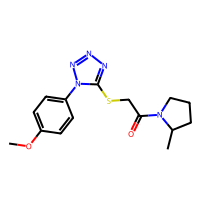
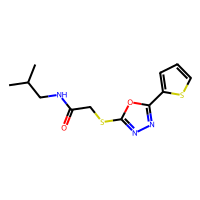
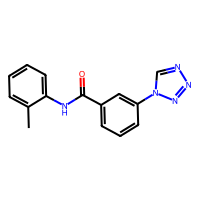
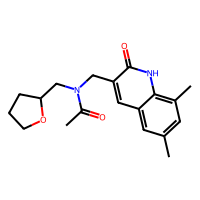
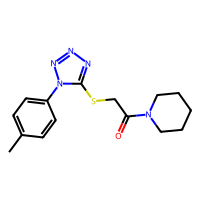
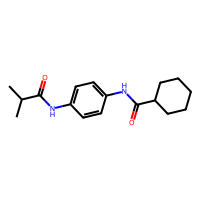
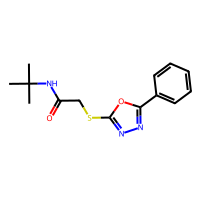
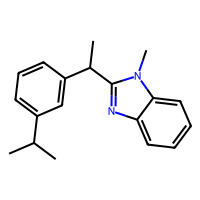
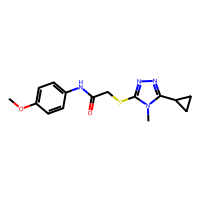
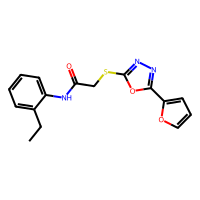
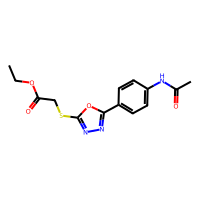
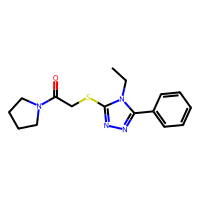
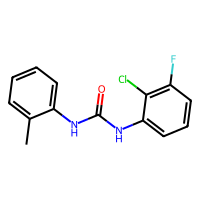
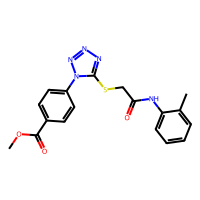
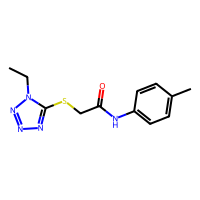
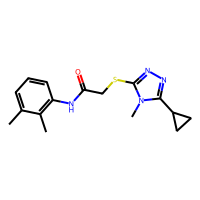
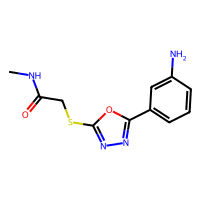
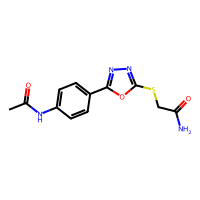
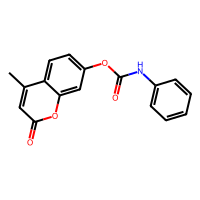
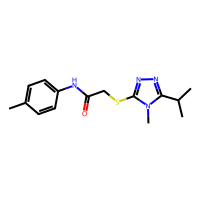
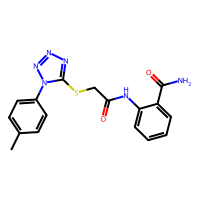
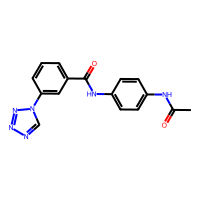
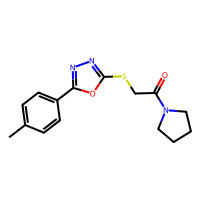
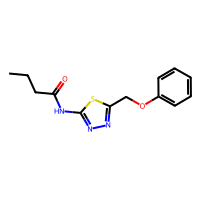
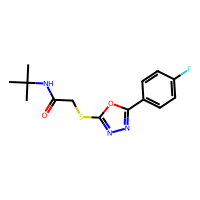
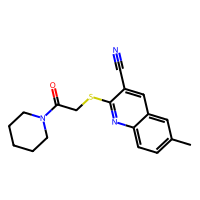
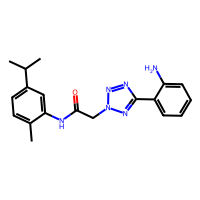
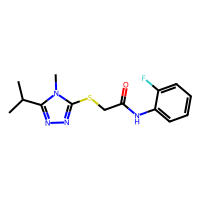
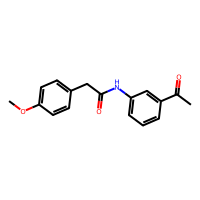
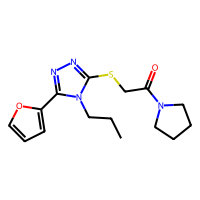
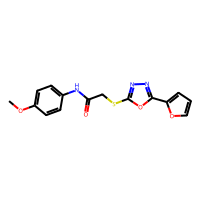
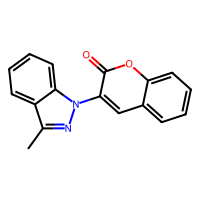
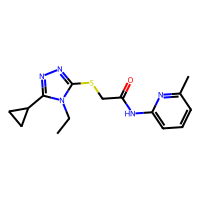
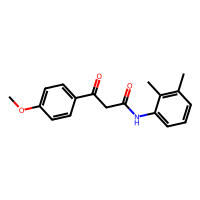
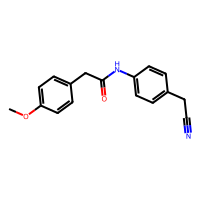
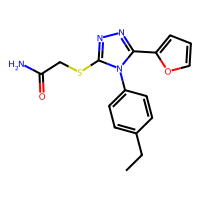
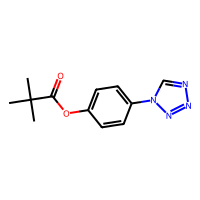
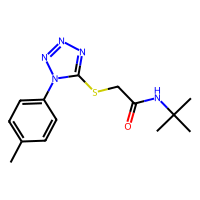
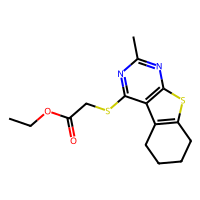
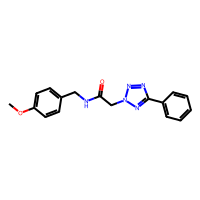
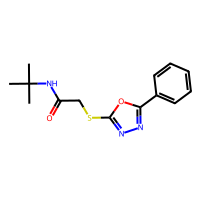
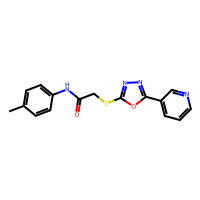
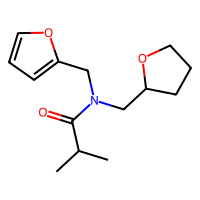
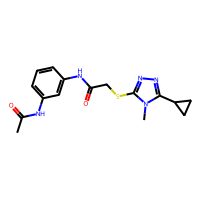
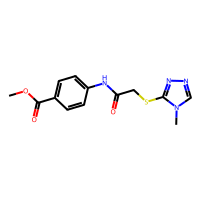
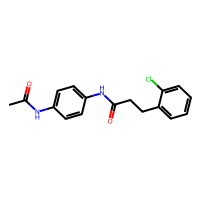
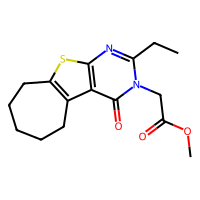

In [ ]:
show(results)

In [ ]:
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem

In [ ]:
fp_list = []
for molecule in molecules:
    fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=1024)
    fp_list.append(fp)

diversity = []
for i in range(len(fp_list)):
    for j in range(i+1, len(fp_list)):
        current_diverity  = 1 - float(TanimotoSimilarity(fp_list[i], fp_list[j]))
        diversity.append(current_diverity)

"Diversity of molecules % = {}".format(np.mean(diversity))

'Diversity of molecules % = 0.7729722352118349'

In [ ]:
with open('gen_gpt_moses_1k.txt', 'w') as f:
    for line in gen_smiles:
        f.write(f"{line}\n")